In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
from invest.data_fetcher import DataFetcher
from invest.portfolio_optimizer import PortfolioOptimizer
from invest.investment_schedule_strategy import InvestmentFrequency
from invest.portfolio_analyzer import InvestStrategy
from invest.rebalance_strategy import RebalanceFrequency
from invest.portfolio_analyzer import PortfolioAnalyzer

In [3]:

class Config:
# Define the constants for the analysis
    START_DATE = "2016-08-01"
    END_DATE = "2024-08-01"
    TICKERS = [
        "AAPL",
        "NVDA",
        "MSFT",
        "AMZN",
        "SPY",
        "GOOG",
        ]
    INVEST_STRATEGY = InvestStrategy(
        investment_frequency=InvestmentFrequency.MONTHLY,
        rebalance_frequency=RebalanceFrequency.YEARLY,
        investment_period_amount=1_000,
    )

config = Config()

In [4]:
data = DataFetcher(config.TICKERS, config.START_DATE, config.END_DATE).fetch_data()

[*********************100%%**********************]  6 of 6 completed


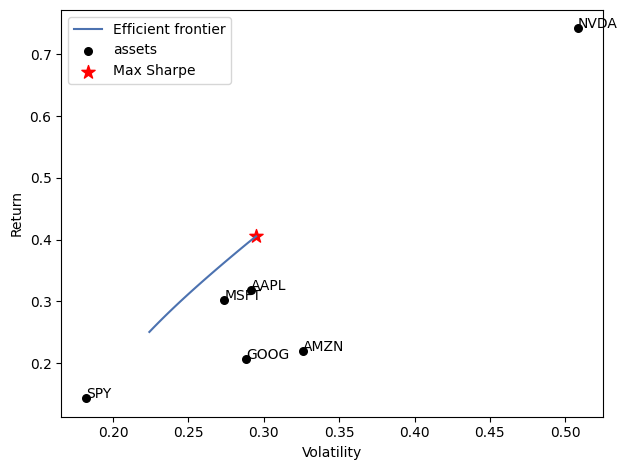

In [5]:
weight_bounds = {
    "AAPL": (0.1, 0.3),
    "NVDA": (0.1, 0.3),
    "MSFT": (0.1, 0.3),
    "AMZN": (0.1, 0.3),
    "SPY": (0.1, 0.5),
    "GOOG": (0.1, 0.5),
}

optimizer = PortfolioOptimizer(data)
weights = optimizer.optimize_portfolio(weight_bounds=weight_bounds)

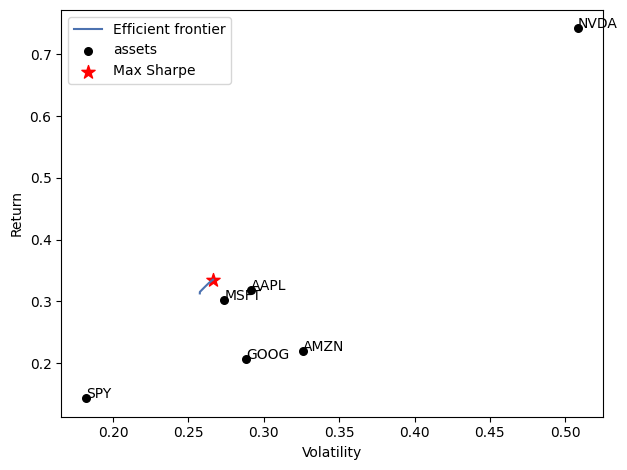

In [6]:
weight_bounds = {
    t: (
        1 / len(config.TICKERS) - 0.1 / len(config.TICKERS),
        1 / len(config.TICKERS) + 0.1 / len(config.TICKERS),
    )
    for t in config.TICKERS
}
weights = optimizer.optimize_portfolio(weight_bounds=weight_bounds)

In [7]:
analyzer = PortfolioAnalyzer(data, weights, config.INVEST_STRATEGY)
cumulative_value_series, total_invested_series = analyzer.invest_periodically()
analyzer.plot_cumulative_value(cumulative_value_series=cumulative_value_series, total_invested_series=total_invested_series)
analyzer.plot_percentage_return(cumulative_value_series=cumulative_value_series, total_invested_series=total_invested_series)